In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

import msastats
from spartaabc.abc_inference import load_data, load_correction_regressors, load_correction_regressor_scores, bias_correction
from spartaabc.utility import get_msa_path, PARAMS_LIST

In [2]:
distance_metric = "mahal"
top_cutoff = 1000
aligner = "mafft"
main_path = Path("/home/elyawy/Data/sparta_benchmark/data").resolve()
print(main_path)

/home/elyawy/Data/sparta_benchmark/data


In [20]:
def get_top_params(main_path: Path):
    MSA_PATH = get_msa_path(main_path)

    empirical_stats = msastats.calculate_fasta_stats(MSA_PATH)

    stats_data = load_data(main_path)
    regressors = load_correction_regressors(main_path, aligner)
    regressor_scores = load_correction_regressor_scores(main_path, aligner)

    params_data = []
    full_stats_data = []
    for model in  stats_data.keys():
        current_regressors = regressors.get(model, None)
        params_data.append(stats_data[model][PARAMS_LIST])

        if current_regressors is not None:
            temp_df, kept_statistics = bias_correction(current_regressors, stats_data[model], regressor_scores)
            full_stats_data.append(temp_df)

    empirical_stats = [empirical_stats[i] for i in kept_statistics]

    params_data = pd.concat(params_data)
    full_stats_data = pd.concat(full_stats_data)

    calculated_distances = None

    if distance_metric == "mahal":
        cov = np.cov(full_stats_data.T)
        cov = cov + np.eye(len(cov))*1e-4
        inv_covmat = np.linalg.inv(cov)
        u_minus_v = empirical_stats-full_stats_data
        left = np.dot(u_minus_v, inv_covmat)
        calculated_distances = np.sqrt(np.sum(u_minus_v*left, axis=1))
    if distance_metric == "euclid":
        weights = 1/(full_stats_data.std(axis=0) + 0.001)
        calculated_distances = np.sum(weights*(full_stats_data - empirical_stats)**2, axis=1)

    full_stats_data["distances"] = calculated_distances
    full_stats_data[PARAMS_LIST] = params_data

    top_stats = full_stats_data.nsmallest(top_cutoff, "distances")
    return top_stats

In [21]:
top_params = {}
for dir in main_path.iterdir():
    try:
        top_params[dir] = get_top_params(dir)
    except:
        continue

In [22]:
def get_indel_model(data_path: Path):
    raw_data = (data_path / "true_params.txt").read_text()
    lines = raw_data.splitlines()[:-1]
    model_params = []
    for line in lines:
        param, value = line.split(": ")
        if param == "Model":
            model_params.append(value)
        if param == "Root_length":
            model_params.append(int(value))
        if param in ["R_I", "R_D", "R_ID", "A_I", "A_D", "A_ID"]:
            model_params.append(float(value))
    return model_params    

In [51]:
def get_all_model_params(data_path: Path, models, abc_params: pd.DataFrame):
    top_cutoff = 100
    true_params = get_indel_model(data_path)

    if true_params[0] == "sim":
        filtered_top_params = abc_params[abc_params["insertion_rate"] == abc_params["deletion_rate"]]
        filtered_top_params = filtered_top_params.nsmallest(top_cutoff, "distances")

        root_length = int(filtered_top_params["root_length"].mean())
        R_ID = float(filtered_top_params["insertion_rate"].mean())
        A_ID = float(filtered_top_params["length_param_insertion"].mean())
        models["sim"]["root_lengths"].append((true_params[1], root_length))
        models["sim"]["indel_rates"].append((true_params[2], R_ID))
        models["sim"]["indel_length_params"].append((true_params[3], A_ID))
    else:
        filtered_top_params = abc_params[abc_params["insertion_rate"] != abc_params["deletion_rate"]]
        filtered_top_params = filtered_top_params.nsmallest(top_cutoff, "distances")
        root_length = int(filtered_top_params["root_length"].mean())
        R_I = float(filtered_top_params["insertion_rate"].mean())
        R_D = float(filtered_top_params["deletion_rate"].mean())
        A_I = float(filtered_top_params["length_param_insertion"].mean())
        A_D = float(filtered_top_params["length_param_deletion"].mean())
        models["rim"]["root_lengths"].append((true_params[1], root_length))
        models["rim"]["insertion_rates"].append((true_params[2], R_I))
        models["rim"]["deletion_rates"].append((true_params[3], R_D))
        models["rim"]["insertion_length_params"].append((true_params[4], A_I))
        models["rim"]["deletion_length_params"].append((true_params[5], A_D))

    return models


In [52]:

models = {"rim":
        {
            "root_lengths": [],
            "insertion_rates": [],
            "deletion_rates": [],
            "insertion_length_params": [],
            "deletion_length_params": []
        },
        "sim":
        {
            "root_lengths": [],
            "indel_rates": [],
            "indel_length_params": [],
        }
    }

for dir in main_path.iterdir():
    try:
        get_all_model_params(dir, models, top_params[dir])
    except:
        continue

In [53]:
def plot_benchmarks(model: str,param: str):
    x, y = zip(*models[model][param])
    r_val = pearsonr(x,y)[0]
    print(r_val)
    plt.scatter(x, y)
    ax = plt.gca()
    ax.text(ax.get_xlim()[1], ax.get_ylim()[0], f"$R^2={r_val**2}$",
            horizontalalignment='right',
            verticalalignment='bottom')

    plt.show()


0.9789143679425771


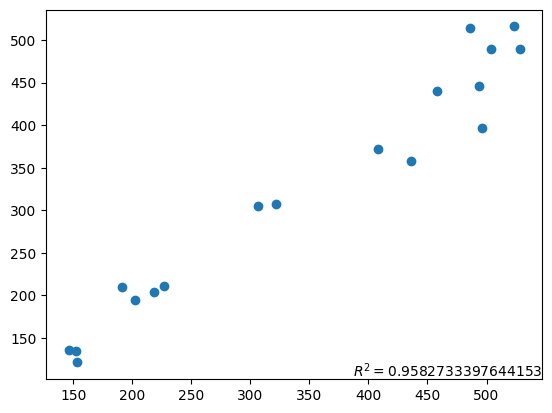

0.7757722570983481


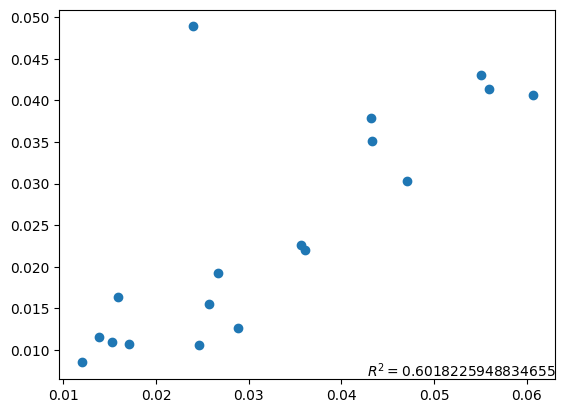

0.7970354276561983


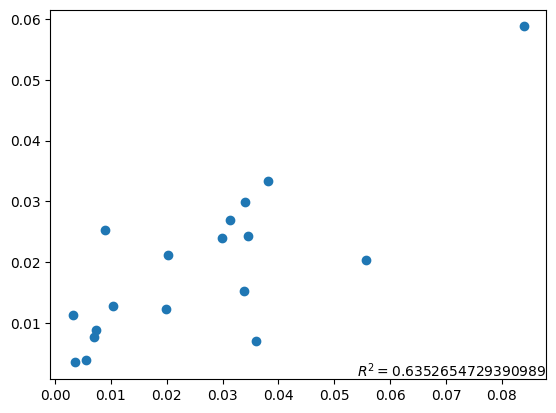

0.6903956072116338


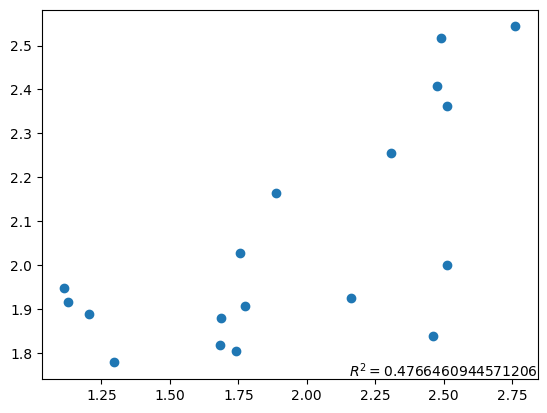

0.676516439924624


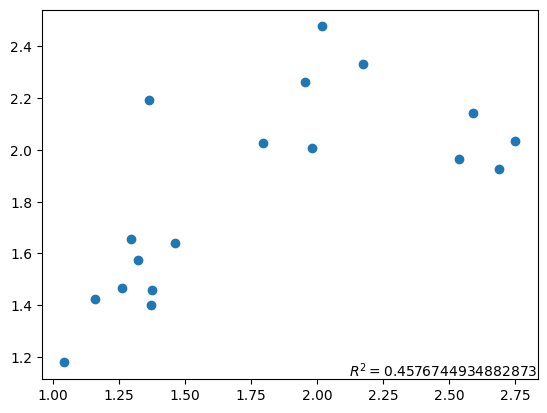

In [54]:
plot_benchmarks("rim", "root_lengths")
plot_benchmarks("rim", "insertion_rates")
plot_benchmarks("rim", "deletion_rates")
plot_benchmarks("rim", "insertion_length_params")
plot_benchmarks("rim", "deletion_length_params")




0.9799019276043718


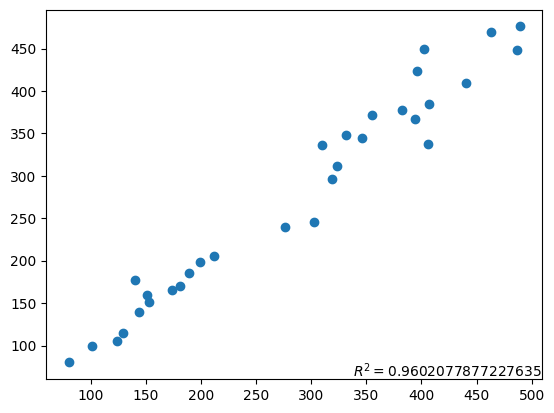

0.8792749528478186


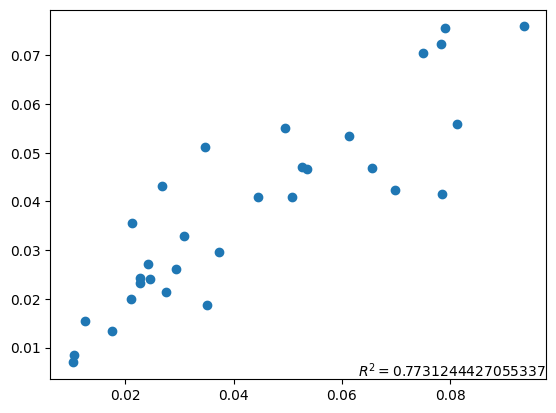

0.9213528581006658


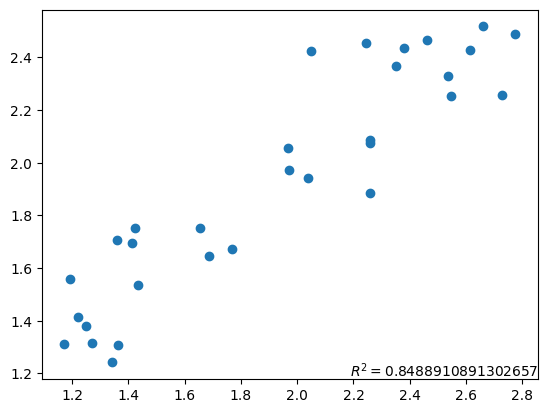

In [55]:
plot_benchmarks("sim", "root_lengths")
plot_benchmarks("sim", "indel_rates")
plot_benchmarks("sim", "indel_length_params")
